In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import json, hashlib





In [9]:
"""General Functions"""

from ising import run_multi_core, set_input
from glob import glob

def dict_to_string(dict):
    t_name=""
    for key, val in dict.items():
        t_name+=str(key)+":"+str(val)+" "
    return t_name


def getRun(params = {}, use_cached=True):
    inp = set_input("")
    for key,value in params.items():
        inp[key]=value

    #print(json.dumps(inp., sort_keys=True))
    inphash = hashlib.md5(json.dumps(inp, sort_keys=True).encode()).hexdigest()
    print(f"input hash: {inphash}")


    allRuns = glob("data/*")
    cached=False
    for run in allRuns:
        if(inphash in run and use_cached):
            print("Using cached run")
            cached=True

    if not cached:
        run_multi_core(inp)

    allRuns = glob("data/*")
    
    allRuns = [run for run in allRuns if inphash in run]

    assert(len(allRuns)==2)

    SCfile = [run for run in allRuns if "SC" in run]
    EMfile = [run for run in allRuns if "EM" in run]

    SC = pd.read_csv(SCfile[0], skiprows=[0,1,2])
    EM = pd.read_csv(EMfile[0], skiprows=[0,1,2])

    return SC, EM

def run(params = {}):
    inp = set_input("")
    for key,value in params.items():
        inp[key]=value


    inpstring = dict_to_string(inp)

    data = run_multi_core(inp)

Tc=2.269


In [20]:
"""Calculate alpha"""


SC,EM = getRun({"t_step":0.01, "flip_perc":0.1, "N":100, "t_min":1.2, "t_max":3.2, "n_burnin":60000, "n_steps":100000, "t_top":4, "B_top":1, "use_gaussian":True})


def spike(x,Tc,a,c):
    return np.abs((x-Tc)/Tc)**-a+c

T=EM["Temp"]
cv=1/T**2*(EM["E_std"]**2)#why is T squared? because beta=1/(kb*T)

plt.plot(T,cv,"o")
plt.errorbar(T,cv,)
plt.axvline(2.269,color="k",linestyle=":", label="Theoretical T_c")


leftTop = np.where(T > Tc)[0][0]
rightBottom = np.where(T<Tc)[0][-1]

leftT=T[0:leftTop]
rightT=T[rightBottom:]

lpopt, lpcov = curve_fit(spike,leftT,cv[0:leftTop], p0=(2.26,0,0))
rpopt, rpcov = curve_fit(spike,rightT,cv[rightBottom:], p0=(2.26,0,0))

plt.plot(leftT,spike(leftT,*lpopt), label=f"t^-{round(lpopt[1]*1e5,2)}e-5")
plt.plot(rightT,spike(rightT,*rpopt), label=f"t^-{round(rpopt[1]*1e5,2)}e-5")


print(lpopt,rpopt)

plt.xlabel("Temperature")
plt.ylabel("C_v")
plt.legend()
#popt,pcov = curve_fit(spike,T,cv, p0=(2.26,0,0))
#plt.plot(T,spike(T,*popt))
#print(popt)
plt.show()
plt.plot(EM["Temp"], abs(EM["M_mean"]))

input hash: 39ee265e71c45702504885c4c52a3c8a.0%  run time: 00:00:21  est.time-to-go: 00:00:01

2D Ising Model Simulation; multi-cores

100x100 (T=1.45) steps:  100000/ 100000, 100.0%  run time: 00:00:23  est.time-to-go:    done!x20 (T=1.27) steps:   10000/ 100000,  10.0%  run time: 00:00:00  est.time-to-go: 00:00:01
100x100 (T=1.44) steps:  100000/ 100000, 100.0%  run time: 00:00:24  est.time-to-go:    done!x20 (T=1.52) steps:   27000/ 100000,  27.0%  run time: 00:00:00  est.time-to-go: 00:00:01
100x100 (T=1.44) steps:  100000/ 100000, 100.0%  run time: 00:00:24  est.time-to-go:    done!
100x100 (T=1.28) steps:  100000/ 100000, 100.0%  run time: 00:00:24  est.time-to-go:    done!x20 (T=1.22) steps:   49000/ 100000,  49.0%  run time: 00:00:01  est.time-to-go: 00:00:01
100x100 (T=1.43) steps:  100000/ 100000, 100.0%  run time: 00:00:25  est.time-to-go:    done!x20 (T=1.54) steps:   66000/ 100000,  66.0%  run time: 00:00:01  est.time-to-go: 00:00:00
20x20 (T=1.49) steps:  100000/ 100000, 

KeyboardInterrupt: 

input hash: 3a52d995224ccb7b5c5436e295f8f708
Using cached run
Using cached run
[2.2        0.09967767 1.1151148 ]


/Users/gfitez/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


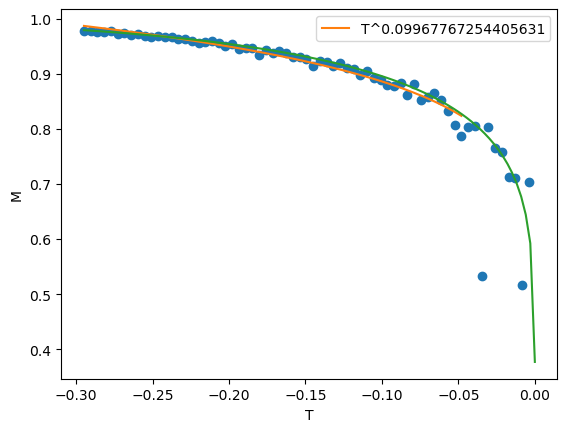

In [212]:
"""Calculate beta"""

#SC,EM = getRun({"t_step":0.01, "flip_perc":0.05, "N":40, "t_min":1.6, "t_max":2.3, "n_burnin":75000, "n_steps":100000, "b_top":10, "t_top":20, "use_gaussian":False})


EM=EM[EM["Temp"]<Tc]

M=abs(EM["M_mean"])
T=(EM["Temp"]-Tc)/Tc
plt.plot(T,M,"o")

def sloop(t,Tc,beta,b):
    return b*np.abs(t)**beta
#def line(x,m,b):
#    return x*m+b

iMin=0
iMax=len(T)-10

popt,pcov = curve_fit(sloop,T[iMin:iMax],M[iMin:iMax],p0=(2.2,1/8,1))
#popt,pcov = curve_fit(line,T[iMin:iMax],M[iMin:iMax])
print(popt)

plt.plot(T[iMin:iMax],sloop(T[iMin:iMax],*popt),label=f"T^{popt[1]}")
plt.xlabel("T")
plt.ylabel("M")
plt.legend()
#plt.yscale("log")
#plt.xscale("log")

def analyticalM(T):
    return (1-np.sinh(2/(T*Tc+Tc))**-4)**0.125

plt.plot(np.linspace(np.min(T),0,100),analyticalM(np.linspace(np.min(T),0,100)))



input hash: 4bfbbd6a62309624c833ad67ed22e8cd
Using cached run
Using cached run
[2.26540081e+00 1.28546665e+00 5.84350320e-05] [2.26954446 0.55602415 0.0025918 ]


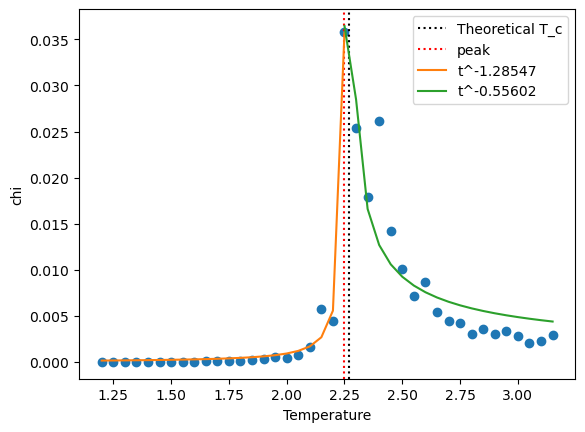

In [3]:
"""Calculate gamma"""

#SC,EM = getRun({"t_step":0.05, "flip_perc":0.2, "N":30, "t_min":1.2, "t_max":3.2, "n_burnin":25000, "n_steps":50000, "t_top":4, "use_gaussian":False})

def chiSpike(x,Tc,a,c):
    #Tc=2.269
    return c*np.abs((x-Tc)/Tc)**-a

T=EM["Temp"]
M=EM["M_mean"]

chi=1/T*EM["M_std"]**2

plt.plot(T,chi,"o")
plt.axvline(2.269,color="k",linestyle=":", label="Theoretical T_c")

peakI=np.argmax(chi)
plt.axvline(T[peakI],color="r",linestyle=":",label="peak")

leftT=T[0:peakI+1]
rightT=T[peakI:]

lpopt, lpcov = curve_fit(chiSpike,leftT,chi[0:peakI+1], p0=(2.26,7/4,0))
rpopt, rpcov = curve_fit(chiSpike,rightT,chi[peakI:], p0=(2.26,7/4,0))

plt.plot(leftT[0:peakI+1],chiSpike(leftT[0:peakI+1],*lpopt), label=f"t^-{round(lpopt[1],5)}")
plt.plot(rightT,chiSpike(rightT,*rpopt), label=f"t^-{round(rpopt[1],5)}")
print(lpopt,rpopt)

plt.xlabel("Temperature")
plt.ylabel("chi")
plt.legend()


input hash: 87ed26d2ab26aad70999a78ecd1e0e53
Using cached run
Using cached run
input hash: e2293f10f8f0f75b54b898c6b854754e
Using cached run
Using cached run
input hash: 0828208901ed4e2b6202fc462dde1415
Using cached run
Using cached run
input hash: 4fbc429b2b963a0f3b7e12566bcb81a7
Using cached run
Using cached run
input hash: 06670f626d2cc0a824d4e4228841a8c6
Using cached run
Using cached run
input hash: 1290abfcc20fca3c70c0c37cd40ec4f7
Using cached run
Using cached run
input hash: 5f07d35eed1ec1fa103a8fecc2111da3
Using cached run
Using cached run
input hash: 6805830e24ff489991f0d30e0e9fe35c
Using cached run
Using cached run
input hash: c84128f16580be72d411a1c2b2642c4a
Using cached run
Using cached run
input hash: 2ea65d87a7bd84666a89262f41a1c7d0
Using cached run
Using cached run
input hash: e6b7c0d40a1514d24ef672a90c8c1229
Using cached run
Using cached run
input hash: 4b24a8477bd328810dcdddd36c51d78f
Using cached run
Using cached run
input hash: 5a4835e027ecd98952eb20eb99c205c4
Using c

Text(0, 0.5, 'M')

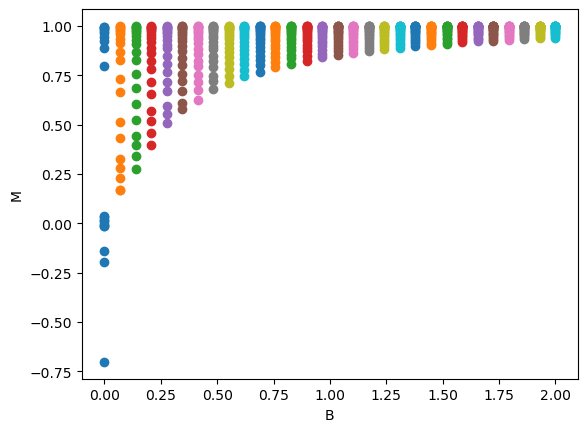

In [17]:
"""Calculate gamma (I realized we actually don't have to do this)"""

Bs=np.linspace(0,2,30)
EMs=[]
for B in Bs:
    SC,EM = getRun({"t_step":0.1, "flip_perc":0.2, "N":30, "t_min":1.2, "t_max":3.2, "n_burnin":25000, "n_steps":50000, "t_top":4, "B":B ,"use_gaussian":False})
    EMs.append(EM)

for EM,B in zip(EMs,Bs):
    M=EM["M_mean"]
    plt.plot([B]*len(M),M,"o")

plt.xlabel("B")
plt.ylabel("M")



input hash: 16c6bf6246aa1ee425c5b573276b9751
Using cached run
Using cached run
[ 1  2  3  4  5  6  7  8  9 10]
[ 0.17001202 -0.00825303  0.01242047]
[ 1  2  3  4  5  6  7  8  9 10]
[ 0.06026529 -0.03073526  0.0360598 ]
[ 1  2  3  4  5  6  7  8  9 10]
[ 0.0703066  -0.02808454  0.03323853]


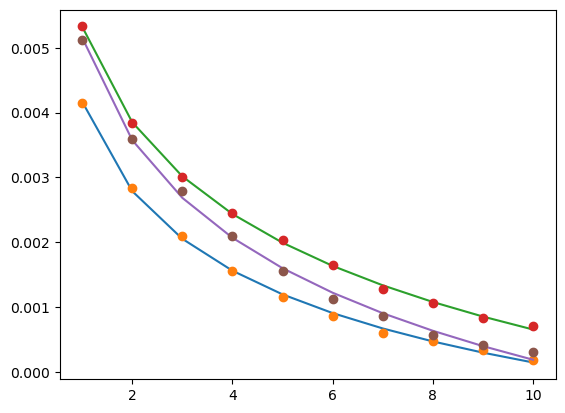

In [129]:
"""Calculate eta"""
#SC,EM = getRun({"t_step":0.01, "flip_perc":0.05, "N":100, "t_min":2.3, "t_max":2.7, "n_burnin":25000, "n_steps":50000, "b_top":10, "t_top":20, "use_gaussian":False})

def correlationFalloff(x,eta,c,a):
    return a*np.abs(x)**(-eta)+c


temps=[]
for i in range(SC.shape[0])[0:3]:
    row = SC.iloc[i]
    temps.append(row[0])

    correlations=row[1:11]
    xVals=np.arange(1,len(correlations)+1)
    print(xVals)

    popt,pcov = curve_fit(correlationFalloff, xVals, correlations, maxfev=5000)
    print(popt)
    plt.plot(xVals, correlationFalloff(xVals, *popt))
    plt.plot(xVals, correlations,"o")

    #xis.append(popt[0])
plt.show()



input hash: 16c6bf6246aa1ee425c5b573276b9751
Using cached run
Using cached run
[ 1  2  3  4  5  6  7  8  9 10]
[2.99146797e+00 5.83906117e-05 5.62021137e-03]
[ 1  2  3  4  5  6  7  8  9 10]
[3.46469994e+00 4.07803985e-04 6.40880448e-03]
[ 1  2  3  4  5  6  7  8  9 10]
[ 3.37061104e+00 -3.84963818e-05  6.84546570e-03]
[ 1  2  3  4  5  6  7  8  9 10]
[ 3.53170780e+00 -3.26126316e-05  6.67502915e-03]
[ 1  2  3  4  5  6  7  8  9 10]
[3.38531816e+00 1.82010355e-04 6.51404464e-03]
[ 1  2  3  4  5  6  7  8  9 10]
[3.18520247e+00 4.34358233e-05 6.40324978e-03]
[ 1  2  3  4  5  6  7  8  9 10]
[2.72767943e+00 8.99800885e-05 7.00100818e-03]
[ 1  2  3  4  5  6  7  8  9 10]
[3.37984579e+00 7.13190704e-05 6.90776013e-03]
[ 1  2  3  4  5  6  7  8  9 10]
[2.91129363e+00 2.56086097e-04 7.00068692e-03]
[ 1  2  3  4  5  6  7  8  9 10]
[ 3.03107287e+00 -3.14612205e-04  7.14293960e-03]
[ 1  2  3  4  5  6  7  8  9 10]
[2.68569486e+00 2.24781152e-04 6.44222336e-03]
[ 1  2  3  4  5  6  7  8  9 10]
[ 2.8076137

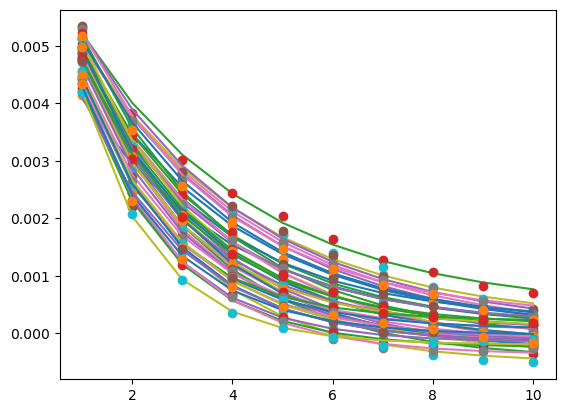

[  0.69348882  -0.47524991 107.15009369]


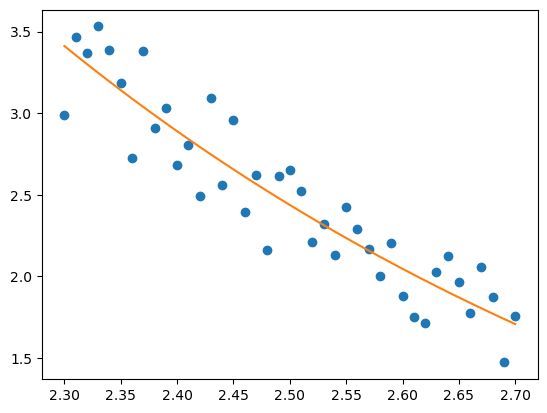

In [121]:
"""Calculate nu"""
#SC,EM = getRun({"t_step":0.01, "flip_perc":0.05, "N":100, "t_min":2.3, "t_max":2.7, "n_burnin":25000, "n_steps":50000, "b_top":10, "t_top":20, "use_gaussian":False})


correlations=[]
temps=[]

def correlationFalloff(d,xi,c,a):
    return a*np.exp(-d/xi)+c


xis=[]
for i in range(SC.shape[0]):
    row = SC.iloc[i]
    temps.append(row[0])

    correlations=row[1:11]
    xVals=np.arange(1,len(correlations)+1)
    print(xVals)

    popt,pcov = curve_fit(correlationFalloff, xVals, correlations)
    print(popt)
    plt.plot(xVals, correlationFalloff(xVals, *popt))
    plt.plot(xVals, correlations,"o")

    xis.append(popt[0])
plt.show()


plt.plot(temps,xis,"o")

def correlationVTemp(t,nu,c,a):
    return a*np.exp(-t/nu)+c

popt,pcov = curve_fit(correlationFalloff, temps, xis, maxfev=5000)
print(popt)

plt.plot(temps,correlationVTemp(np.array(temps), *popt))

